In [ ]:
# !pip install wordcloud
# !pip install git+https://github.com/minimaxir/textgenrnn.git

     |████████████████████████████████| 461 kB 3.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import random

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import pickle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from pylab import rcParams
import warnings

warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /home/htet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/htet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/htet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/htet/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Load data
path = "/home/htet/Documents/backup/sentiment_analysis_of_amazon_product_reviews"
reviews = pd.read_csv(path + r'/data/amazon_reviews.csv')
print("Number of records:", len(reviews))
reviews.head()

Number of records: 568454


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
# Check NULL values in the columns of "Score" and "Text"
print('Number of NULL records in Score:', reviews['Score'].isnull().sum())
print('Number of NULL records in Text:', reviews['Text'].isnull().sum())

Number of NULL records in Score: 0
Number of NULL records in Text: 0


In [ ]:
# Delete redundant columns
cols_deleted = ["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Time", "Summary"]
if all(col in reviews.columns for col in cols_deleted):
    reviews = reviews.drop(cols_deleted, axis=1)

In [ ]:
# The number of words per review
words_per_review = reviews.Text.apply(lambda x: len(x.split(" ")))
print('Average words per review:', words_per_review.mean())

Average words per review: 82.00552199474363


In [ ]:
# Separate the scores into new DataFrames
reviews_1 = reviews[reviews["Score"]==1]
reviews_2 = reviews[reviews["Score"]==2]
reviews_3 = reviews[reviews["Score"]==3]
reviews_4 = reviews[reviews["Score"]==4]
reviews_5 = reviews[reviews["Score"]==5]

# Randomly reduce the size of score 4 and 5 without replacement
reviews_4 = reviews_4.sample(len(reviews_1), replace=False, random_state=42)
reviews_5 = reviews_5.sample(len(reviews_1), replace=False, random_state=42)

reduced_size_reviews = pd.concat([reviews_1, reviews_2, reviews_3, reviews_4, reviews_5], ignore_index=True)
reduced_size_review_counts = reduced_size_reviews["Score"].value_counts()

In [ ]:
# Split train, validation and test data on each score
reviews_1_test = reviews_1.sample(round(len(reviews_1)*20/100), replace=False, random_state=42)
reviews_1_train = reviews_1.drop(reviews_1_test.index)
reviews_1_val = reviews_1_train.sample(round(len(reviews_1_train)*20/100), replace=False, random_state=42)
reviews_1_train = reviews_1_train.drop(reviews_1_val.index)

reviews_2_test = reviews_2.sample(round(len(reviews_2)*20/100), replace=False, random_state=42)
reviews_2_train = reviews_2.drop(reviews_2_test.index)
reviews_2_val = reviews_2_train.sample(round(len(reviews_2_train)*20/100), replace=False, random_state=42)
reviews_2_train = reviews_2_train.drop(reviews_2_val.index)

reviews_4_test = reviews_4.sample(round(len(reviews_4)*20/100), replace=False, random_state=42)
reviews_4_train = reviews_4.drop(reviews_4_test.index)
reviews_4_val = reviews_4_train.sample(round(len(reviews_4_train)*20/100), replace=False, random_state=42)
reviews_4_train = reviews_4_train.drop(reviews_4_val.index)

reviews_5_test = reviews_5.sample(round(len(reviews_5)*20/100), replace=False, random_state=42)
reviews_5_train = reviews_5.drop(reviews_5_test.index)
reviews_5_val = reviews_5_train.sample(round(len(reviews_5_train)*20/100), replace=False, random_state=42)
reviews_5_train = reviews_5_train.drop(reviews_5_val.index)

# Concatenate train, validation and test data
resampled_review_train = pd.concat([reviews_1_train, reviews_2_train, reviews_4_train, reviews_5_train], ignore_index=True)
resampled_review_val = pd.concat([reviews_1_val, reviews_2_val, reviews_4_val, reviews_5_val], ignore_index=True)
resampled_review_test = pd.concat([reviews_1_test, reviews_2_test, reviews_4_test, reviews_5_test], ignore_index=True)

print("Train size: ", len(resampled_review_train))
print("Validation size: ", len(resampled_review_val))
print("Test size: ", len(resampled_review_test))

Train size:  119405
Validation size:  29852
Test size:  37316


In [ ]:
# Standardize the ratings for sentiment analysis
resampled_review_train['Sentiment'] = np.where(resampled_review_train.Score > 3, 'positive', 'negative')
resampled_review_train['Sentiment'] = resampled_review_train['Sentiment'].replace({'negative': 0, 'positive': 1})
review_count_train = resampled_review_train['Sentiment'].value_counts()
sentiment_label_train = review_count_train.index.values

resampled_review_val['Sentiment'] = np.where(resampled_review_val.Score > 3, 'positive','negative')
resampled_review_val['Sentiment'] = resampled_review_val['Sentiment'].replace({'negative': 0, 'positive': 1})

resampled_review_test['Sentiment'] = np.where(resampled_review_test.Score > 3, 'positive', "negative")
resampled_review_test['Sentiment'] = resampled_review_test['Sentiment'].replace({'negative': 0, 'positive': 1})

In [ ]:
# Convert words to lower case
resampled_review_train['Text'] = resampled_review_train['Text'].str.lower()

# Remove special characters
resampled_review_train['Text'] = resampled_review_train['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
resampled_review_val['Text'] = resampled_review_val['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
resampled_review_test['Text'] = resampled_review_test['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
print("\n***Review after converting to lower case and removing special characters***")
print(resampled_review_train['Text'][0])

# Remove stopwords and lemmatize the words
stop_words = stopwords.words('english')
print("\n***Stopwords***")
print(stop_words)

lemmatizer = WordNetLemmatizer()

resampled_review_train['Text'] = resampled_review_train['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
resampled_review_val['Text'] = resampled_review_val['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
resampled_review_test['Text'] = resampled_review_test['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
print("\n***Reviews after removing stopwords and lemmating the words***")
resampled_review_train['Text'][0]


***Review after converting to lower case and removing special characters***
product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as "jumbo".

***Stopwords***
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

"product arrive label jumbo salt peanuts ... peanuts actually small size unsalted . sure error vendor intend represent product `` jumbo '' ."

In [ ]:
# Delete redundant column
resampled_review_train = resampled_review_train.drop('Score', axis=1)
resampled_review_val = resampled_review_val.drop('Score', axis=1)
resampled_review_test = resampled_review_test.drop('Score', axis=1)
resampled_review_train.head()

,Text,Sentiment
0,product arrive label jumbo salt peanuts ... pe...,0
1,"candy red , flavor . plan chewy . would never buy",0
2,"oatmeal good . mushy , soft , n't like . quake...",0
3,single sell $ 2.50 - $ 3.36 store 1 box 24 sin...,0
4,seriously product tasteless come . much better...,0


In [ ]:
# Check NULL values in columns
print('***Train***')
print('Number of NULL records in Text: ', resampled_review_train.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_train.Sentiment.isnull().sum())
print('***Validation***')
print('Number of NULL records in Text: ', resampled_review_val.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_val.Sentiment.isnull().sum())
print('***Test***')
print('Number of NULL records in Text: ', resampled_review_test.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_test.Sentiment.isnull().sum())

***Train***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0
***Validation***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0
***Test***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0


In [ ]:
# Random resampling the data
resampled_review_train = resampled_review_train.sample(len(resampled_review_train), replace=False, random_state=42)
resampled_review_val = resampled_review_val.sample(len(resampled_review_val), replace=False, random_state=42)
resampled_review_test = resampled_review_test.sample(len(resampled_review_test), replace=False, random_state=42)

In [ ]:
# Split X and y data
X_train = resampled_review_train['Text']
y_train = resampled_review_train['Sentiment']
X_val = resampled_review_val['Text']
y_val = resampled_review_val['Sentiment']
X_test = resampled_review_test['Text']
y_test = resampled_review_test['Sentiment']

In [ ]:
# Undersample train data
X_train = np.array(X_train).reshape(-1, 1)
under = RandomUnderSampler(sampling_strategy='all', random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
X_train_under = np.array(X_train_under).reshape(-1)
X_train_under = pd.Series(X_train_under)

print("X_train_under shape: ", X_train_under.shape)
print("y_train_under shape: ", y_train_under.shape)

X_train_under shape:  (105006,)
y_train_under shape:  (105006,)


In [ ]:
# Train TF-IDF model to vectorize input data
tfidf = TfidfVectorizer(tokenizer= word_tokenize, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_under)

tfidf_path = path + "/tfidf_models/tfidf_ngram1-2/model_tfidf.pkl"

# Save the model
with open(tfidf_path, 'wb') as f:
    pickle.dump(tfidf, f)

# Transform the data
X_train_tfidf = tfidf.transform(X_train_under)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)
X_train_tfidf

<105006x1220781 sparse matrix of type '<class 'numpy.float64'>'
	with 9916594 stored elements in Compressed Sparse Row format>

In [ ]:
# Normalize matrices
scaler = MaxAbsScaler()
X_train_norm = scaler.fit_transform(X_train_tfidf)
X_val_norm = scaler.transform(X_val_tfidf)
X_test_norm = scaler.transform(X_test_tfidf)

In [ ]:
# Train logistic regression model
logreg = LogisticRegression(solver='sag', penalty='l2', tol=0.001, max_iter=30, C=5, random_state=42)
logreg.fit(X_train_norm, y_train_under)

# Evaluate the model
score_train_logreg = logreg.score(X_train_norm, y_train_under)
score_valid_logreg = cross_val_score(logreg, X_val_norm, y_val, cv=10).mean()
print('Training accuracy:', score_train_logreg)
print('Validation accuracy:', score_valid_logreg)
print('\n***Coefficient***')
print(logreg.coef_)
print('\n***Intercept***')
print(logreg.intercept_)

logreg_path = path + r"/tfidf_models/tfidf_ngram1-2/model_logreg.pkl"

# Save the model
with open(logreg_path, 'wb') as f:
    pickle.dump(logreg, f)

# Test the model
score_test_logreg = logreg.score(X_test_norm, y_test)
print('\nTesting accuracy:', score_test_logreg)

Training accuracy: 0.9910957469097004
Validation accuracy: 0.8730064926104063

***Coefficient***
[[ 1.73225423 -2.48367136  0.00671943 ... -0.04261053 -0.03108608
  -0.03108608]]

***Intercept***
[-0.12586464]

Testing accuracy: 0.9069300032157788


In [ ]:
# Calculate precision, recall and F1 score
pred_logreg = logreg.predict(X_test_norm)
precision_logreg = precision_score(y_test, pred_logreg)
recall_logreg = recall_score(y_test, pred_logreg)
f1_logreg = f1_score(y_test, pred_logreg)
print("Precision:", precision_logreg)
print("Recall:", recall_logreg)
print("F1 score:", f1_logreg)

Precision: 0.9278107670412721
Recall: 0.9042471781136407
F1 score: 0.9158774373259053


Confusion matirx of testing data


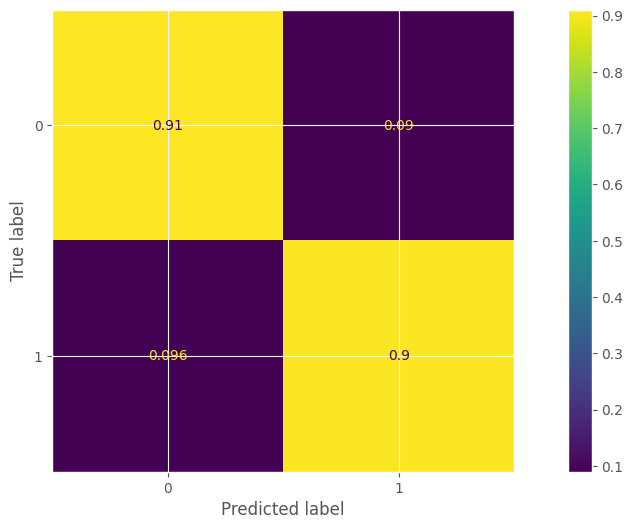

In [ ]:
# Confusion matrices
pred_logreg = logreg.predict(X_test_norm);
cm_logreg = confusion_matrix(y_test, pred_logreg);
cm_logreg
cm_logreg_norm = cm_logreg / cm_logreg.sum(axis=1).reshape(-1,1)

# Display confusion matrix
cm_logreg_dis = ConfusionMatrixDisplay(confusion_matrix=cm_logreg_norm, display_labels=logreg.classes_);
print("Confusion matirx of testing data")
cm_logreg_dis.plot()

In [ ]:
# Fitting logistic regression
lsvm = LinearSVC(penalty='l2', loss='squared_hinge', tol= 0.01,  max_iter=30, C=0.1, dual=False, random_state=42, multi_class='ovr')
lsvm.fit(X_train_norm, y_train_under)


# Evaluate the model
score_train_lsvm = lsvm.score(X_train_norm, y_train_under)
score_valid_lsvm = cross_val_score(lsvm, X_val_norm, y_val, cv=10).mean()
print('Training accuracy:', score_train_lsvm)
print('Validation accuracy:', score_valid_lsvm)
print('\n***Coefficient***')
print(lsvm.coef_)
print('\n***Intercept***')
print(lsvm.intercept_)


lsvm_path = path + r"/tfidf_models/tfidf_ngram1-2/model_lsvm.pkl"

with open(lsvm_path, 'wb') as f:
    pickle.dump(lsvm, f)

# Test the model
score_test_lsvm = lsvm.score(X_test_norm, y_test)
print('Testing accuracy:', score_test_lsvm)

Training accuracy: 0.9998000114279184
Validation accuracy: 0.8849653604032666

***Coefficient***
[[ 0.48001624 -0.69669064 -0.0008977  ... -0.0173747  -0.01134096
  -0.01134096]]

***Intercept***
[-0.05248834]
Testing accuracy: 0.9115660842534034


In [ ]:
# Calculate precision, recall and F1 score
pred_lsvm = lsvm.predict(X_test_norm)
precision_lsvm = precision_score(y_test, pred_lsvm)
recall_lsvm = recall_score(y_test, pred_lsvm)
f1_lsvm = f1_score(y_test, pred_lsvm)
print("Precision:", precision_lsvm)
print("Recall:", recall_lsvm)
print("F1 score:", f1_lsvm)

Precision: 0.9284601907728246
Recall: 0.9124736942797016
F1 score: 0.9203975299112312


Confusion matirx of testing data


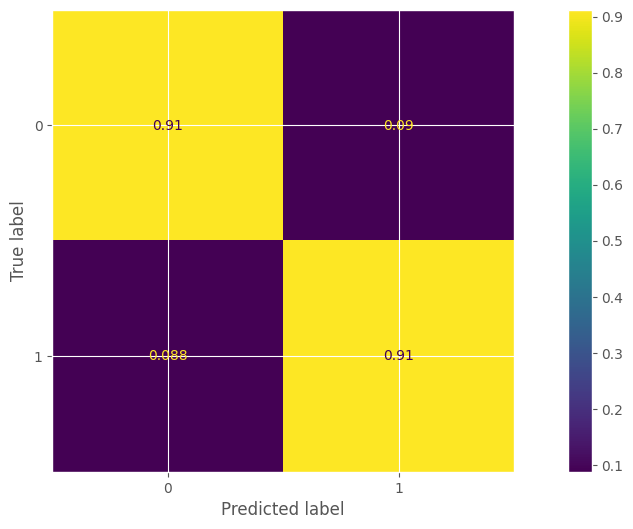

In [ ]:
# Confusion matrices
pred_lsvm = lsvm.predict(X_test_norm);
cm_lsvm = confusion_matrix(y_test, pred_lsvm);
cm_lsvm_norm = cm_lsvm / cm_lsvm.sum(axis=1).reshape(-1,1)

# Display confusion matrix for test
cm_lsvm_dis = ConfusionMatrixDisplay(confusion_matrix=cm_lsvm_norm, display_labels=lsvm.classes_);
print("Confusion matirx of testing data")
cm_lsvm_dis.plot()

In [ ]:
# Train Naive Bayes
bnb = BernoulliNB(alpha=0.1)
bnb.fit(X_train_norm, y_train_under)

# Evaluate the model
score_train_bnb = bnb.score(X_train_norm, y_train_under)
score_valid_bnb = cross_val_score(bnb, X_val_norm, y_val, cv=10).mean()
print('Training accuracy:', score_train_bnb)
print('Validation accuracy:', score_valid_bnb)

bnb_path = path + r"/tfidf_models/tfidf_ngram1-2/model_bnb.pkl"

with open(bnb_path, 'wb') as f:
    pickle.dump(bnb, f)

# Test the model
score_test_bnb = bnb.score(X_test_norm, y_test)
print('Testing accuracy:', score_test_bnb)

Training accuracy: 0.9876007085309411
Validation accuracy: 0.8430922866172793
Testing accuracy: 0.8798102690534891


In [ ]:
# Calculate precision, recall and F1 score
pred_bnb = bnb.predict(X_test_norm)
precision_bnb = precision_score(y_test, pred_bnb)
recall_bnb = recall_score(y_test, pred_bnb)
f1_bnb = f1_score(y_test, pred_bnb)
print("Precision:", precision_bnb)
print("Recall:", recall_bnb)
print("F1 score:", f1_bnb)

Precision: 0.8584712096738988
Recall: 0.9405490721255022
F1 score: 0.8976377952755905


Confusion matirx of Bernoulli NB


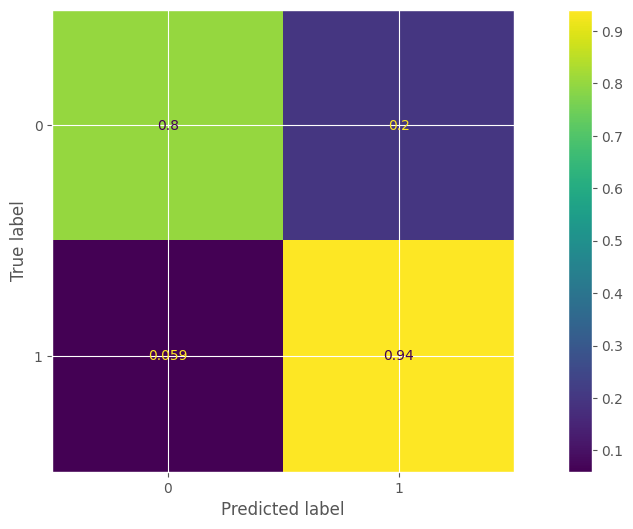

In [ ]:
# Confusion matrices
cm_bnb = confusion_matrix(y_test, pred_bnb);
cm_bnb_norm = cm_bnb / cm_bnb.sum(axis=1).reshape(-1,1)

# Display confusion matrix for test
cm_bnb_dis = ConfusionMatrixDisplay(confusion_matrix=cm_bnb_norm, display_labels=bnb.classes_);
print("Confusion matirx of Bernoulli NB")
cm_bnb_dis.plot()

In [ ]:
# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=150, random_state=42)
rfc.fit(X_train_norm, y_train_under)

# Evaluate the model
score_train_rfc = rfc.score(X_train_norm, y_train_under)
score_valid_rfc = cross_val_score(rfc, X_val_norm, y_val, cv=10).mean()
print('Training accuracy:', score_train_rfc)
print('Validation accuracy:', score_valid_rfc)

rfc_path = path + r"/tfidf_models/tfidf_ngram1-2/model_rfc.pkl"

with open(rfc_path, 'wb') as f:
    pickle.dump(rfc, f)

# Test the model
score_test_rfc = rfc.score(X_test_norm, y_test)
print('Testing accuracy:', score_test_rfc)

Training accuracy: 0.9934765632440051
Validation accuracy: 0.8296928379338084
Testing accuracy: 0.8884124772215671


In [ ]:
# Calculate precision, recall and F1 score
pred_rfc = rfc.predict(X_test_norm)
precision_rfc = precision_score(y_test, pred_rfc)
recall_rfc = recall_score(y_test, pred_rfc)
f1_rfc = f1_score(y_test, pred_rfc)
print("Precision:", precision_rfc)
print("Recall:", recall_rfc)
print("F1 score:", f1_rfc)

Precision: 0.8923516730715156
Recall: 0.9107040367323512
F1 score: 0.9014344553330492


In [ ]:
# Confusion matrices
pred_rfc = rfc.predict(X_test_norm);
cm_rfc = confusion_matrix(y_test, pred_rfc);
cm_rfc_norm = cm_rfc / cm_rfc.sum(axis=1).reshape(-1,1)

# Display confusion matrix for test
cm_rfc_dis = ConfusionMatrixDisplay(confusion_matrix=cm_rfc_norm, display_labels=rfc.classes_);
print("Confusion matirx of Random Forest Classifier using Gini")
cm_rfc_dis.plot()